In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import SelectKBest, mutual_info_regression
# from sklearn.preprocessing import PolynomialFeatures

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Load actual data from the Excel file
actual_data = pd.read_excel("../DATAFORMODELtrain200824.xlsx")

# Convert 'Date' to datetime format
actual_data['Date'] = pd.to_datetime(actual_data['Date'], format='%m/%d/%Y %H:%M')



In [ ]:
# Filter the actual data to the specified date range
start_date = "2024-07-01 23:00"
end_date = "2024-08-20 23:00"
actual_data_filtered = actual_data[(actual_data['Date'] >= start_date) & (actual_data['Date'] <= end_date)]

# Load forecast data from the CSV file
forecast_data = pd.read_csv("../forecast_output.csv")

# Convert 'ds' to datetime format
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

# Filter the forecast data to the specified date range
forecast_data_filtered = forecast_data[(forecast_data['ds'] >= start_date) & (forecast_data['ds'] <= end_date)]


In [ ]:
# Merge actual and forecasted data on the date column
merged_data = pd.merge(actual_data_filtered[['Date', 'PriceSK']],
                       forecast_data_filtered[['ds', 'yhat']],
                       left_on='Date',
                       right_on='ds',
                       how='inner')

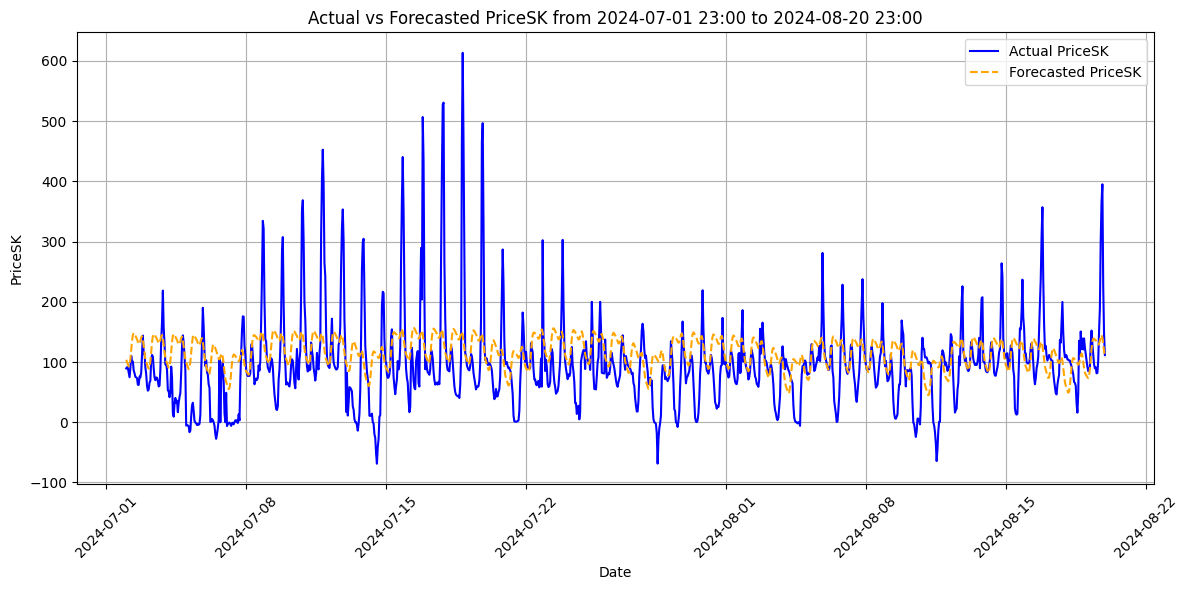

In [ ]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['PriceSK'], label='Actual PriceSK', color='blue')
plt.plot(merged_data['Date'], merged_data['yhat'], label='Forecasted PriceSK', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('PriceSK')
plt.title('Actual vs Forecasted PriceSK from 2024-07-01 23:00 to 2024-08-20 23:00')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Engineering Basic

In [ ]:
actual_data.head()

,Date,Y,M,Day,H,PriceHU,PriceSK,PriceRO,PriceCZ,PMIHU,GAS,COAL,CO2,COALTOGAS,WDAY,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,Y2022,Y2023,Y2024,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL
0,2015-12-31 23:59:59.995,2016,1,1,1,32.90,16.50,32.90,16.50,49.1,15.3,47.75,7.45,3.120915,1,1,1,1,0,-5.493333,-1.353333,-6.556667,-4.290694,-9.638594,9.506667,70.824667,3403.386667,-1.751667,-5.918333,128.3689,11.33,-7.67,0.0,2.09,0.0,153.7600,12.40,-3.60,0.00,4.42,0.0,249.3241,15.79,-5.21,0.0,5.24,0.0,0.0,25.0,87.0,112.0,125.0,0.0,0.0,0.0,0.0,0,207.0,917.0,1234.0,194,439,0,1219.0,1943.0,0,0,227,227,0,0,0,787,787,0,7210,1524,564.0,232.0,3237.0,4303.0,194.0,358.0,358.0,2135.0,9289.0,0.0,0.0,0.0,445,0,65,510,374.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,330.796471,379.353680,2126.807144,0.0,0.0,-1.972778,562.0,432,432,0,0.0,0.0,2171.643928,6998,8734,4033.0
1,2016-01-01 01:00:00.000,2016,1,1,2,33.34,15.50,33.34,15.50,49.1,15.3,47.75,7.45,3.120915,1,1,1,1,0,-5.503333,-1.353333,-6.556667,-4.290694,-9.638594,9.496667,70.750167,3124.403333,-1.816667,-6.223333,120.1216,10.96,-8.04,0.0,2.06,0.0,161.5441,12.71,-3.29,0.00,3.69,0.0,250.2724,15.82,-5.18,0.0,5.17,0.0,0.0,168.0,87.0,255.0,125.0,0.0,0.0,0.0,0.0,122,956.0,1378.0,2639.0,194,909,0,1514.0,2238.0,0,0,227,227,0,0,0,787,787,0,7210,1524,1156.0,1124.0,3993.0,6146.0,194.0,329.0,329.0,2173.0,8724.0,0.0,0.0,0.0,445,0,65,510,407.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,357.704351,398.913699,2139.439377,0.0,0.0,-2.074444,562.0,432,432,0,0.0,0.0,2185.977244,6446,8734,6273.0
2,2016-01-01 02:00:00.000,2016,1,1,3,30.95,14.00,30.95,14.00,49.1,15.3,47.75,7.45,3.120915,1,1,1,1,0,-5.580000,-1.353333,-6.556667,-4.290694,-9.638594,9.420000,70.179000,3023.820000,-1.894167,-6.475833,112.9969,10.63,-8.37,0.0,2.03,0.0,167.4436,12.94,-3.06,0.00,2.86,0.0,246.1761,15.69,-5.31,0.0,4.85,0.0,0.0,168.0,87.0,255.0,125.0,0.0,0.0,0.0,0.0,122,956.0,1378.0,2639.0,194,909,0,1528.0,2252.0,0,0,227,227,0,0,0,787,787,0,7210,1524,1156.0,1124.0,4007.0,6160.0,194.0,321.0,321.0,2176.0,8694.0,0.0,0.0,0.0,445,0,0,445,357.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,384.642458,418.466355,2152.153538,0.0,0.0,-2.158611,562.0,432,432,0,0.0,0.0,2200.296989,6434,8734,6287.0
3,2016-01-01 03:00:00.000,2016,1,1,4,26.28,10.01,26.28,10.01,49.1,15.3,47.75,7.45,3.120915,1,1,1,1,0,-5.783333,-1.353333,-6.556667,-4.290694,-9.638594,9.216667,68.664167,3142.883333,-1.970833,-6.659167,107.5369,10.37,-8.63,0.0,2.04,0.0,173.7124,13.18,-2.82,0.00,2.14,0.0,228.0100,15.10,-5.90,0.0,4.30,0.0,0.0,168.0,87.0,255.0,125.0,0.0,0.0,0.0,0.0,122,956.0,1378.0,2639.0,194,909,0,1528.0,2252.0,0,0,227,227,0,0,0,787,787,0,7210,1524,1156.0,1124.0,4007.0,6160.0,194.0,341.0,341.0,2180.0,8468.0,0.0,0.0,0.0,445,0,0,445,389.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,411.609123,437.980176,2165.367163,0.0,0.0,-2.219722,562.0,432,432,0,0.0,0.0,2214.584783,63

In [ ]:
data = actual_data.copy()

In [ ]:
data_new = actual_data.copy()

In [ ]:
# Define the cutoff date
cutoff_date = pd.to_datetime("2024-08-20 23:00")
# Keep data from 2017 onwards
start_date = pd.to_datetime('2017-01-01 00:00')
data = data[data['Date'] >= start_date]

# Filter data to only include rows up to the cutoff date
data = data[data['Date'] <= cutoff_date]

In [ ]:
data_new = data_new[data_new['Date'] >= start_date]

# Filter data to only include rows up to the cutoff date
data_new = data_new[data_new['Date'] <= cutoff_date]

In [ ]:
columns_to_drop = [
    'Y', 'M', 'Day', 'H', 'Y2016',	'Y2017',	'Y2018',	'Y2019',	'Y2020',	'Y2021',	'Y2022',	'Y2023',	'Y2024',
    'M1',	'M2',	'M3',	'M4',	'M5',	'M6',	'M7',	'M8',	'M9',	'M10',	'M11',	'M12',
    'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
    'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19',
    'h20', 'h21', 'h22', 'h23', 'h24',
    'PriceCZ', 'PriceSK', 'PriceRO', 'WDAY',
]

In [ ]:
data = data.drop(columns=columns_to_drop)

In [ ]:
data_new = data_new.drop(columns=columns_to_drop)


In [ ]:
def count_nulls_per_column(df, columns):
    # Dictionary to store the number of nulls for each column
    null_counts = {}

    for column in columns:
        # Count the number of nulls in each column
        null_counts[column] = df[column].isnull().sum()

    # Print the total number of nulls for each column
    print("Total number of null values per column:")
    for column, count in null_counts.items():
        print(f"{column}: {count} nulls")

In [ ]:
columns_to_check = ['PriceHU', 'COAL', 'GAS', 'AT_HU', 'COALTOGAS', 'CO2', 'UNAVHYDRALL', 'UNAVLIGNSK', 'UNAVHYDRBG', 'Date', 'RHBSOLGEN', 'RORAT_HP','ATWINDGEN']
count_nulls_per_column(data, columns_to_check)

Total number of null values per column:
PriceHU: 0 nulls
COAL: 0 nulls
GAS: 0 nulls
AT_HU: 0 nulls
COALTOGAS: 0 nulls
CO2: 0 nulls
UNAVHYDRALL: 0 nulls
UNAVLIGNSK: 0 nulls
UNAVHYDRBG: 0 nulls
Date: 0 nulls
RHBSOLGEN: 0 nulls
RORAT_HP: 0 nulls
ATWINDGEN: 0 nulls


In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Get the correlations of all columns with 'PriceSK'
price_sk_correlation = correlation_matrix['PriceHU'].sort_values(ascending=False)

# Display the most relevant features that correlate with 'PriceSK'
print(price_sk_correlation)

PriceHU         1.000000
GAS             0.871612
COAL            0.793855
CO2             0.582177
UNAVHYDRBG      0.518509
T2MALLPCO2      0.510297
UNAVGASBG       0.492151
UNAVGASALL      0.486935
UNAVHYDRALL     0.449667
UNAVTPPHU       0.406717
Date            0.406636
UNAVGASHU       0.400937
UNAVGASSK       0.398411
UNAVNUCFR       0.392739
UNAVALLFR       0.367399
UNAVTPPSK       0.315292
UA_SK           0.256427
SOLMAX          0.247859
UNAVGASCZ       0.206753
UNAVHYDRRO      0.181699
UNAVLIGNHU      0.174780
PL_SK           0.164874
PMIHU           0.141359
UNAVTPPBG       0.116580
UNAVHYDRFR      0.109677
UNAVGASGR       0.104828
UNAVNUCHU       0.092012
UADEM           0.090550
T2MALLNONLIN    0.082645
HUSOLGEN        0.073420
T2MROPSQ        0.071165
T2MHUPSQ        0.067655
T2MRO           0.061798
T2MROP          0.061798
T2MSKPSQ        0.059874
T2MALLP         0.055628
T2MALL          0.055628
T2MALLMIN       0.055172
T2MHUP          0.053629
T2MHU           0.053629


In [ ]:
# Handling Missing Values
# data = data.interpolate(method='linear')  # Example of linear interpolation
# data = data.interpolate(method='spline', order=3)

# Feature Engineering
data['hour'] = data['Date'].dt.hour
data['day_of_week'] = data['Date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['month'] = data['Date'].dt.month
data['rolling_mean_7d'] = data['PriceHU'].rolling(window=7).mean()  # Example of rolling mean
data['lag_1'] = data['PriceHU'].shift(1)  # Example of lag feature

In [ ]:
# Lagged Features
data['lag_2'] = data['PriceHU'].shift(2)
data['lag_3'] = data['PriceHU'].shift(3)
data['lag_6'] = data['PriceHU'].shift(6)
data['lag_12'] = data['PriceHU'].shift(12)
data['lag_24'] = data['PriceHU'].shift(24)

In [ ]:
# Rolling Statistics
data['rolling_mean_3h'] = data['PriceHU'].rolling(window=3).mean()
data['rolling_mean_12h'] = data['PriceHU'].rolling(window=12).mean()
data['rolling_mean_24h'] = data['PriceHU'].rolling(window=24).mean()

data['rolling_std_3h'] = data['PriceHU'].rolling(window=3).std()
data['rolling_std_12h'] = data['PriceHU'].rolling(window=12).std()
data['rolling_std_24h'] = data['PriceHU'].rolling(window=24).std()

data['ewm_12h'] = data['PriceHU'].ewm(span=12).mean()  # Exponentially weighted moving average with span of 12 hours
data['ewm_24h'] = data['PriceHU'].ewm(span=24).mean()  # Exponentially weighted moving average with span of 24 hours

In [ ]:
# Fourier Transform (FFT) Features
fft_vals = fft(data['PriceHU'].values)

# Adding FFT features (real and imaginary parts)
data['fft_real'] = np.real(fft_vals)
data['fft_imag'] = np.imag(fft_vals)

# Optional: Adding the magnitude of the FFT values to capture the strength of frequency components
data['fft_magnitude'] = np.abs(fft_vals)

In [ ]:
# Select only numeric columns for spline interpolation
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Perform spline interpolation on numeric columns
# data[numeric_columns] = data[numeric_columns].interpolate(method='spline', order=2)

# Verify that there are no NaN values left in numeric columns
print("Number of NaN values after spline interpolation:\n", data[numeric_columns].isna().sum())

Number of NaN values after spline interpolation:
 PriceHU              0
PMIHU                0
GAS                  0
COAL                 0
CO2                  0
COALTOGAS            0
DOFFHU               0
DOFFSK               0
DOFFRO               0
WND                  0
T2MALL               0
T2MALLMAX            0
T2MALLMIN            0
T2MALLAV             0
T2MALLNONLIN         0
T2MALLP              0
T2MALLPCO2           0
T2MALLPROR           0
T2MHUNORM            0
THUDEVNORM           0
T2MHUPSQ             0
T2MHUP               0
T2MHU                0
PRECHU               0
WS10MHU              0
ALLSKY1HU            0
T2MSKPSQ             0
T2MSKP               0
T2MSK                0
PRECSK               0
WS10MSK              0
ALLSKY1SK            0
T2MROPSQ             0
T2MROP               0
T2MRO                0
PRECRO               0
WS10MRO              0
ALLSKY1RO            0
UNAVNUCHU            0
UNAVGASHU            0
UNAVLIGNHU           0
UNAVTPP

In [ ]:
# Drop rows with any remaining NaN values
data = data.dropna()

# Check if all NaN values are handled
print("Number of NaN values after dropping:\n", data.isna().sum())

Number of NaN values after dropping:
 Date                0
PriceHU             0
PMIHU               0
GAS                 0
COAL                0
CO2                 0
COALTOGAS           0
DOFFHU              0
DOFFSK              0
DOFFRO              0
WND                 0
T2MALL              0
T2MALLMAX           0
T2MALLMIN           0
T2MALLAV            0
T2MALLNONLIN        0
T2MALLP             0
T2MALLPCO2          0
T2MALLPROR          0
T2MHUNORM           0
THUDEVNORM          0
T2MHUPSQ            0
T2MHUP              0
T2MHU               0
PRECHU              0
WS10MHU             0
ALLSKY1HU           0
T2MSKPSQ            0
T2MSKP              0
T2MSK               0
PRECSK              0
WS10MSK             0
ALLSKY1SK           0
T2MROPSQ            0
T2MROP              0
T2MRO               0
PRECRO              0
WS10MRO             0
ALLSKY1RO           0
UNAVNUCHU           0
UNAVGASHU           0
UNAVLIGNHU          0
UNAVTPPHU           0
UNAVNUCSK       

In [ ]:
# Define your feature matrix X and target variable y
X = data.drop(['PriceHU', 'Date'], axis=1)
y = data['PriceHU']
# Step 1: Feature Importance using RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

In [ ]:
# Mutual Information for Feature Selection
X = data.drop(['PriceHU', 'Date'], axis=1)
y = data['PriceHU']

# Ensure all columns are numeric or properly formatted for mutual_info_regression
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

mi = mutual_info_regression(X, y)
mi_scores = pd.Series(mi, name="MI Scores", index=X.columns).sort_values(ascending=False)


In [ ]:
print(mi_scores)

rolling_mean_3h     1.855979
lag_1               1.765801
lag_2               1.202206
ewm_12h             1.134833
rolling_mean_7d     1.064542
lag_24              1.037124
ewm_24h             0.973591
lag_3               0.908595
rolling_mean_24h    0.902239
GAS                 0.898543
rolling_mean_12h    0.894729
COAL                0.882541
UNAVGASRO           0.785058
PMIHU               0.781951
COALTOGAS           0.756590
CO2                 0.736089
UNAVGASHU           0.690950
UNAVTPPBG           0.672230
UNAVTPPRO           0.620539
UNAVGASALL          0.615347
UNAVLIGNRO          0.607074
UNAVHYDRALL         0.599510
lag_12              0.584408
lag_6               0.577577
UNAVTPPHU           0.564109
UNAVTPPGR           0.556425
UNAVLIGNBG          0.547160
rolling_std_24h     0.537098
UNAVGASGR           0.526438
UNAVHYDRBG          0.502757
SOLMAX              0.464217
UNAVNUCALL          0.462274
UNAVTPPCZ           0.420424
UNAVNUCFR           0.419410
UNAVLIGNCZ    

In [ ]:
print(mi_scores)

rolling_mean_3h     1.855979
lag_1               1.765801
lag_2               1.202206
ewm_12h             1.134833
rolling_mean_7d     1.064542
lag_24              1.037124
ewm_24h             0.973591
lag_3               0.908595
rolling_mean_24h    0.902239
GAS                 0.898543
rolling_mean_12h    0.894729
COAL                0.882541
UNAVGASRO           0.785058
PMIHU               0.781951
COALTOGAS           0.756590
CO2                 0.736089
UNAVGASHU           0.690950
UNAVTPPBG           0.672230
UNAVTPPRO           0.620539
UNAVGASALL          0.615347
UNAVLIGNRO          0.607074
UNAVHYDRALL         0.599510
lag_12              0.584408
lag_6               0.577577
UNAVTPPHU           0.564109
UNAVTPPGR           0.556425
UNAVLIGNBG          0.547160
rolling_std_24h     0.537098
UNAVGASGR           0.526438
UNAVHYDRBG          0.502757
SOLMAX              0.464217
UNAVNUCALL          0.462274
UNAVTPPCZ           0.420424
UNAVNUCFR           0.419410
UNAVLIGNCZ    

In [ ]:
# Retain top N features based on MI scores
top_features = mi_scores[mi_scores > 0.5].index  # For example, keep features with MI score > 0.5
X_filtered = X[top_features]

In [ ]:
# Calculate the correlation matrix
corr_matrix = X_filtered.corr()

# Identify highly correlated features
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:  # Set your threshold here
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

# Drop highly correlated features
X_uncorrelated = X_filtered.drop(columns=correlated_features)
print("Uncorrelated Features:", X_uncorrelated.columns)

Uncorrelated Features: Index(['rolling_mean_3h', 'UNAVGASRO', 'PMIHU', 'COALTOGAS', 'CO2',
       'UNAVGASHU', 'UNAVTPPBG', 'UNAVTPPRO', 'UNAVGASALL', 'UNAVHYDRALL',
       'UNAVTPPGR', 'rolling_std_24h', 'UNAVGASGR'],
      dtype='object')


In [ ]:
# Calculate the correlation matrix
corr_matrix = X_filtered.corr()

# Identify moderately correlated features (0.3 < |correlation| < 0.8)
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
potential_interactions = corr_pairs[(corr_pairs > 0.3) & (corr_pairs < 0.8)]
print("Potential Feature Interactions based on Correlation:\n", potential_interactions)

Potential Feature Interactions based on Correlation:
 lag_1             COAL                0.793816
COAL              lag_2               0.793772
lag_3             COAL                0.793742
COAL              lag_6               0.793687
lag_12            COAL                0.793605
lag_24            COAL                0.793232
UNAVTPPRO         UNAVGASRO           0.738823
CO2               UNAVHYDRBG          0.726497
rolling_mean_24h  rolling_std_24h     0.712716
rolling_std_24h   ewm_24h             0.711310
CO2               UNAVLIGNRO          0.707699
ewm_12h           rolling_std_24h     0.702111
rolling_mean_12h  rolling_std_24h     0.699009
CO2               UNAVTPPRO           0.697044
rolling_mean_7d   rolling_std_24h     0.686323
GAS               rolling_std_24h     0.680161
rolling_mean_3h   rolling_std_24h     0.671290
lag_1             rolling_std_24h     0.664448
rolling_std_24h   lag_2               0.664377
lag_12            rolling_std_24h     0.664198
lag_3 

In [ ]:
# Select only numeric columns for spline interpolation
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Perform spline interpolation on numeric columns
# data[numeric_columns] = data[numeric_columns].interpolate(method='spline', order=2)

# Verify that there are no NaN values left in numeric columns
print("Number of NaN values after spline interpolation:\n", data[numeric_columns].isna().sum())

Number of NaN values after spline interpolation:
 PriceHU             0
PMIHU               0
GAS                 0
COAL                0
CO2                 0
COALTOGAS           0
DOFFHU              0
DOFFSK              0
DOFFRO              0
WND                 0
T2MALL              0
T2MALLMAX           0
T2MALLMIN           0
T2MALLAV            0
T2MALLNONLIN        0
T2MALLP             0
T2MALLPCO2          0
T2MALLPROR          0
T2MHUNORM           0
THUDEVNORM          0
T2MHUPSQ            0
T2MHUP              0
T2MHU               0
PRECHU              0
WS10MHU             0
ALLSKY1HU           0
T2MSKPSQ            0
T2MSKP              0
T2MSK               0
PRECSK              0
WS10MSK             0
ALLSKY1SK           0
T2MROPSQ            0
T2MROP              0
T2MRO               0
PRECRO              0
WS10MRO             0
ALLSKY1RO           0
UNAVNUCHU           0
UNAVGASHU           0
UNAVLIGNHU          0
UNAVTPPHU           0
UNAVNUCSK           0
UNAV

In [ ]:
# Drop rows with any remaining NaN values
data = data.dropna()

# Check if all NaN values are handled
print("Number of NaN values after dropping:\n", data.isna().sum())

Number of NaN values after dropping:
 Date                0
PriceHU             0
PMIHU               0
GAS                 0
COAL                0
CO2                 0
COALTOGAS           0
DOFFHU              0
DOFFSK              0
DOFFRO              0
WND                 0
T2MALL              0
T2MALLMAX           0
T2MALLMIN           0
T2MALLAV            0
T2MALLNONLIN        0
T2MALLP             0
T2MALLPCO2          0
T2MALLPROR          0
T2MHUNORM           0
THUDEVNORM          0
T2MHUPSQ            0
T2MHUP              0
T2MHU               0
PRECHU              0
WS10MHU             0
ALLSKY1HU           0
T2MSKPSQ            0
T2MSKP              0
T2MSK               0
PRECSK              0
WS10MSK             0
ALLSKY1SK           0
T2MROPSQ            0
T2MROP              0
T2MRO               0
PRECRO              0
WS10MRO             0
ALLSKY1RO           0
UNAVNUCHU           0
UNAVGASHU           0
UNAVLIGNHU          0
UNAVTPPHU           0
UNAVNUCSK       

In [ ]:
# Convert the 'Date' column to the nearest hour to ensure minutes and seconds are 00
data['Date'] = data['Date'].dt.round('H')

In [ ]:
# Print the filtered data to verify
print("\nData from 2017 onwards:")
data.head()



Data from 2017 onwards:


,Date,PriceHU,PMIHU,GAS,COAL,CO2,COALTOGAS,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL,hour,day_of_week,is_weekend,month,rolling_mean_7d,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3h,rolling_mean_12h,rolling_mean_24h,rolling_std_3h,rolling_std_12h,rolling_std_24h,ewm_12h,ewm_24h,fft_real,fft_imag,fft_magnitude
8809,2017-01-02 00:59:59.998,23.45,52.2,19.48,90.1,4.59,4.625257,0,0,1,0,-6.606667,2.286667,-7.54,-4.457500,-9.805400,8.393333,38.5254,3659.493333,-1.267500,-6.112500,135.0244,11.62,-7.38,0.0,2.44,0.0,66.7489,8.17,-7.83,0.0,0.84,0.0,268.6321,16.39,-4.61,0.0,2.75,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,408.0,1881.0,2594.0,361,470,0,1573.0,1948.0,0,0,0,0,0,0,0,787,787,0,9975,3308,470.0,626.0,4241.0,5657.0,361.0,436.0,676.0,2457.0,12707.0,0.0,0.0,0.0,625,0,20,645,196.0,200,613.779028,565.881159,2537.935776,0.0,0.0,-2.037500,583.0,0,831,0,0.0,0.0,2643.302006,9671,13283,5337.0,0,0,0,1,43.211429,24.84,42.78,43.51,57.97,45.32,50.21,30.356667,46.694167,38.788750,10.781347,12.566432,14.794352,40.999615,41.352244,-189455.927297,185119.353648,264882.471076
8810,2017-01-02 01:59:59.998,20.89,52.2,19.48,90.1,4.59,4.625257,0,0,1,0,-6.720000,2.286667,-7.54,-4.471667,-9.819567,8.280000,38.0052,3419.640000,-1.427500,-6.112500,131.3316,11.46,-7.54,0.0,2.50,0.0,65.2864,8.08,-7.92,0.0,0.65,0.0,265.6900,16.30,-4.70,0.0,3.03,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,408.0,1881.0,2594.0,361,470,0,1518.0,1893.0,0,0,0,0,0,0,0,787,787,0,9405,3308,470.0,626.0,4186.0,5602.0,361.0,413.0,513.0,2497.0,12595.0,0.0,0.0,0.0,615,0,20,635,150.0,154,617.722462,560.291994,2525.447526,0.0,0.0,-2.037500,583.0,0,831,0,0.0,0.0,2645.540528,9808,12713,5282.0,1,0,0,1,37.914286,23.45,24.84,42.78,57.96,41.34,44.04,23.060000,44.990000,37.824167,2.003672,14.583319,15.186571,37.865104,39.503771,-137419.905702,-43554.816998,144157.041337
8811,2017-01-02 02:59:59.998,19.95,52.2,19.48,90.1,4.59,4.625257,0,0,1,0,-6.880000,2.286667,-7.54,-4.493889,-9.841789,8.120000,37.2708,3239.880000,-1.468333,-6.201667,128.3689,11.33,-7.67,0.0,2.62,0.0,67.7329,8.23,-7.77,0.0,0.62,0.0,249.6400,15.80,-5.20,0.0,3.54,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,408.0,1881.0,2594.0,361,470,0,1518.0,1893.0,0,0,0,0,0,0,0,787,787,0,9405,3308,470.0,626.0,4186.0,5602.0,361.0,399.0,540.0,2446.0,12539.0,0.0,0.0,0.0,615,0,20,635,132.0,200,624.161764,554.497360,2523.263819,0.0,0.0,-2.067222,583.0,0,831,0,0.0,0.0,2649.173154,10039,12713,5282.0,2,0,0,1,32.484286,20.89,23.45,24.84,51.97,44.17,32.81,21.430000,42.971667,37.288333,1.811408,16.283986,15.592624,35.078298,37.755436,62975.698027,-127509.777201,142213.507881
8812,2017-01-02 03:59:59.998,22.81,52.2,19.48,90.1,4.59,4.625257,0,0,1,0,-7.100000,2.286667,-7.54,-4.520694,-10.616419,7.900000,36.2610,3610.300000,-1.570833,-6.269167,124.5456,11.16,-7.84,0.0,2.49,0.0,68.3929,8.27,-7.73,0.0,0.73,0.0,233.1729,15.27,-5.73,0.0,3.97,0.0,0.0,218.0,0.0,218.0,0.0,0.0,0.0,110.0,0.0,0,408.0,1881.0,2594.0,361,470,0,1518.0,1893.0,0,0,0,0,0,0,0,787,787,0,9405,3308,470.0,626.0,4186.0,5602.0,361.0,457.0,308.0,2434.0,12015.0,0.0,0.0,0.0,615,0,20,635,263.0,200,633.082998,548.826748,2532.131743,0.0,0.0,-2.089722,583.0,0,831,0,0.0,0.0,265

In [ ]:
# Filter pairs to keep only those with moderate correlation (0.3 < |correlation| < 0.8)
selected_pairs = corr_pairs[(corr_pairs.abs() > 0.5) & (corr_pairs.abs() < 0.8)]

In [ ]:
# Print the selected feature pairs
print("Selected Feature Pairs for Interaction based on Correlation and Domain Knowledge:")
for (feature_1, feature_2), corr_value in selected_pairs.items():
    # Ensure we print each pair only once
    if feature_1 != feature_2:
        print(f"{feature_1} and {feature_2} with Correlation: {corr_value:.3f}")

Selected Feature Pairs for Interaction based on Correlation and Domain Knowledge:
lag_1 and COAL with Correlation: 0.794
COAL and lag_2 with Correlation: 0.794
lag_3 and COAL with Correlation: 0.794
COAL and lag_6 with Correlation: 0.794
lag_12 and COAL with Correlation: 0.794
lag_24 and COAL with Correlation: 0.793
UNAVTPPRO and UNAVGASRO with Correlation: 0.739
CO2 and UNAVHYDRBG with Correlation: 0.726
rolling_mean_24h and rolling_std_24h with Correlation: 0.713
rolling_std_24h and ewm_24h with Correlation: 0.711
CO2 and UNAVLIGNRO with Correlation: 0.708
ewm_12h and rolling_std_24h with Correlation: 0.702
rolling_mean_12h and rolling_std_24h with Correlation: 0.699
CO2 and UNAVTPPRO with Correlation: 0.697
rolling_mean_7d and rolling_std_24h with Correlation: 0.686
GAS and rolling_std_24h with Correlation: 0.680
rolling_mean_3h and rolling_std_24h with Correlation: 0.671
lag_1 and rolling_std_24h with Correlation: 0.664
rolling_std_24h and lag_2 with Correlation: 0.664
lag_12 and r

In [ ]:
# Creating interaction terms
for (feature1, feature2) in selected_pairs.index:  # Use .index to get the feature pairs
    interaction_name = f"{feature1}_x_{feature2}"
    data[interaction_name] = data[feature1] * data[feature2]

print("Interaction terms added to the DataFrame.")


Interaction terms added to the DataFrame.


In [ ]:
lasso = LassoCV(cv=10)
lasso.fit(X_filtered, y)

# Get the coefficients of the features
lasso_coefficients = pd.Series(lasso.coef_, index=X_filtered.columns).sort_values(ascending=False)

# Filter features based on non-zero coefficients
selected_features = lasso_coefficients[lasso_coefficients != 0].index
X_selected = X_filtered[selected_features]
print("Selected Features based on Lasso:", selected_features)

Selected Features based on Lasso: Index(['rolling_mean_3h', 'lag_24', 'rolling_mean_24h', 'lag_12', 'UNAVHYDRBG',
       'UNAVGASALL', 'UNAVHYDRALL', 'UNAVLIGNRO', 'UNAVLIGNBG', 'lag_3',
       'lag_2'],
      dtype='object')


In [ ]:
# Initialize the model
rf = RandomForestRegressor()
rfe = RFE(estimator=rf, n_features_to_select=10)  # Adjust the number of features to keep
rfe.fit(X_filtered, y)

# Get the ranking of features
feature_ranking = pd.Series(rfe.ranking_, index=X_filtered.columns).sort_values()
selected_rfe_features = feature_ranking[feature_ranking == 1].index
print("Selected Features based on RFE:", selected_rfe_features)

KeyboardInterrupt: 

In [ ]:
# # Step 3: Combine RF Importances and Mutual Information Scores
# feature_scores = pd.DataFrame({
#     'RandomForestImportance': rf_importances,
#     'MutualInformation': mi_scores
# })

# # Normalize the scores to compare effectively
# feature_scores['RF_Score_Norm'] = (feature_scores['RandomForestImportance'] - feature_scores['RandomForestImportance'].min()) / (feature_scores['RandomForestImportance'].max() - feature_scores['RandomForestImportance'].min())
# feature_scores['MI_Score_Norm'] = (feature_scores['MutualInformation'] - feature_scores['MutualInformation'].min()) / (feature_scores['MutualInformation'].max() - feature_scores['MutualInformation'].min())


In [ ]:
# # Calculate a combined score
# feature_scores['CombinedScore'] = feature_scores['RF_Score_Norm'] + feature_scores['MI_Score_Norm']

In [ ]:
# # Select top features based on the combined score
# top_features = feature_scores.sort_values('CombinedScore', ascending=False).head(20).index.tolist()

# print("Top features for Polynomial Expansion based on combined importance scores:")
# print(top_features)

Top features for Polynomial Expansion based on combined importance scores:
['rolling_mean_3h', 'lag_1', 'lag_2', 'ewm_12h', 'rolling_mean_7d', 'lag_24', 'ewm_24h', 'lag_3', 'rolling_mean_24h', 'GAS', 'rolling_mean_12h', 'COAL', 'UNAVGASRO', 'PMIHU', 'COALTOGAS', 'CO2', 'UNAVGASHU', 'UNAVTPPBG', 'UNAVTPPRO', 'UNAVGASALL']


In [ ]:
# # List of new features to add
# new_features = ['RHBSOLGEN', 'RORAT_HP', 'ATWINDGEN']

# # Your existing polynomial features list
# polynomial_features = top_features  # Assuming `top_features` is already defined

# # Append only the new features that are not already in the list
# polynomial_features.extend([feature for feature in new_features if feature not in polynomial_features])

# # Verify the updated list
# print("Updated list of features for polynomial expansion:", polynomial_features)

Updated list of features for polynomial expansion: ['rolling_mean_3h', 'lag_1', 'lag_2', 'ewm_12h', 'rolling_mean_7d', 'lag_24', 'ewm_24h', 'lag_3', 'rolling_mean_24h', 'GAS', 'rolling_mean_12h', 'COAL', 'UNAVGASRO', 'PMIHU', 'COALTOGAS', 'CO2', 'UNAVGASHU', 'UNAVTPPBG', 'UNAVTPPRO', 'UNAVGASALL', 'RHBSOLGEN', 'RORAT_HP', 'ATWINDGEN']


In [ ]:
# print(polynomial_features)

['rolling_mean_3h', 'lag_1', 'lag_2', 'ewm_12h', 'rolling_mean_7d', 'lag_24', 'ewm_24h', 'lag_3', 'rolling_mean_24h', 'GAS', 'rolling_mean_12h', 'COAL', 'UNAVGASRO', 'PMIHU', 'COALTOGAS', 'CO2', 'UNAVGASHU', 'UNAVTPPBG', 'UNAVTPPRO', 'UNAVGASALL', 'RHBSOLGEN', 'RORAT_HP', 'ATWINDGEN']


In [ ]:
# Drop rows with any remaining NaN values
# data = data.dropna()

In [ ]:
data.head()

,Date,PriceHU,PMIHU,GAS,COAL,CO2,COALTOGAS,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL,hour,day_of_week,is_weekend,month,rolling_mean_7d,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3h,rolling_mean_12h,rolling_mean_24h,rolling_std_3h,rolling_std_12h,rolling_std_24h,ewm_12h,ewm_24h,fft_real,fft_imag,fft_magnitude,lag_1_x_COAL,COAL_x_lag_2,lag_3_x_COAL,COAL_x_lag_6,lag_12_x_COAL,lag_24_x_COAL,UNAVTPPRO_x_UNAVGASRO,CO2_x_UNAVHYDRBG,rolling_mean_24h_x_rolling_std_24h,rolling_std_24h_x_ewm_24h,CO2_x_UNAVLIGNRO,ewm_12h_x_rolling_std_24h,rolling_mean_12h_x_rolling_std_24h,CO2_x_UNAVTPPRO,rolling_mean_7d_x_rolling_std_24h,GAS_x_rolling_std_24h,rolling_mean_3h_x_rolling_std_24h,lag_1_x_rolling_std_24h,rolling_std_24h_x_lag_2,lag_12_x_rolling_std_24h,lag_3_x_rolling_std_24h,lag_6_x_rolling_std_24h,rolling_std_24h_x_lag_24,GAS_x_COALTOGAS,CO2_x_COAL,COALTOGAS_x_CO2,rolling_std_24h_x_COAL,UNAVHYDRALL_x_CO2,CO2_x_ewm_24h,CO2_x_rolling_mean_24h,ewm_24h_x_COALTOGAS,COALTOGAS_x_rolling_mean_24h,CO2_x_GAS,CO2_x_ewm_12h,CO2_x_rolling_mean_12h,ewm_12h_x_COALTOGAS,rolling_mean_12h_x_COALTOGAS,rolling_mean_7d_x_CO2,GAS_x_UNAVHYDRBG,rolling_mean_7d_x_COALTOGAS,UNAVGASALL_x_COAL,CO2_x_rolling_mean_3h,rolling_std_24h_x_CO2,COAL_x_COALTOGAS,COAL_x_UNAVHYDRBG,COALTOGAS_x_rolling_mean_3h,UNAVHYDRBG_x_rolling_std_24h,lag_1_x_CO2,lag_2_x_CO2,CO2_x_lag_3,lag_6_x_CO2,CO2_x_lag_24,CO2_x_lag_12,COALTOGAS_x_lag_6,COALTOGAS_x_lag_2,lag_3_x_COALTOGAS,COALTOGAS_x_lag_1,COALTOGAS_x_lag_12,lag_24_x_COALTOGAS,GAS_x_UNAVGASALL,ewm_24h_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_24h,ewm_12h_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_12h,UNAVTPPBG_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_7d,UNAVGASRO_x_UNAVLIGNRO,rolling_std_24h_x_COALTOGAS,UNAVHYDRBG_x_rolling_mean_3h,rolling_mean_24h_x_UNAVGASALL,CO2_x_UNAVTPPBG,UNAVGASALL_x_ewm_24h,lag_24_x_UNAVHYDRBG,lag_12_x_UNAVHYDRBG,lag_6_x_UNAVHYDRBG,UNAVHYDRBG_x_lag_3,UNAVHYDRBG_x_lag_2,UNAVHYDRALL_x_UNAVTPPBG,UNAVHYDRBG_x_lag_1,UNAVHYDRALL_x_GAS,UNAVGASALL_x_ewm_12h,rolling_std_24h_x_UNAVHYDRALL,COALTOGAS_x_UNAVHYDRBG,rolling_mean_12h_x_UNAVGASALL,rolling_mean_7d_x_UNAVGASALL,RHBSOLGEN,RORAT_HP,ATWINDGEN,rolling_mean_3h,lag_1,lag_2,ewm_12h,rolling_mean_7d,lag_24,ewm_24h,lag_3,rolling_mean_24h,GAS,rolling_mean_12h,COAL,UNAVGASRO,PMIHU,COALTOGAS,CO2,RHBSOLGEN^2,RHBSOLGEN RORAT_HP,RHBSOLGEN ATWINDGEN,RHBSOLGEN rolling_mean_3h,RHBSOLGEN lag_1,RHBSOLGEN lag_2,RHBSOLGEN ewm_12h,RHBSOLGEN rolling_mean_7d,RHBSOLGEN lag_24,RHBSOLGEN ewm_24h,RHBSOLGEN lag_3,RHBSOLGEN rolling_mean_24h,RHBSOLGEN GAS,RHBSOLGEN rolling_mean_12h,RHBSOLGEN COAL,RHBSOLGEN UNAVGASRO,RHBSOLGEN PMIHU,RHBSOLGEN COALTOGAS,RHBSOLGEN CO2,RORAT_HP^2,RORAT_HP ATWINDGEN,RORAT_HP rolling_mean_3h,RORAT_HP lag_1,RORAT_HP lag_2,RORAT_HP ewm_12h,RORAT_HP rolling_mean_7d,RORAT_HP lag_24,RORAT_HP ewm_24h,RORAT_HP lag_3,RORAT_HP rolling_mean_24h,RORAT_HP GAS,RORAT_HP rolling_mean_12h,RORAT_HP COAL,RORAT_HP UNAVGASRO,RORAT_HP PMIHU,RORAT_HP COALTOGAS,RORAT_HP CO2,ATWINDGEN^2,ATWINDGEN rolling_mean_3h,ATWINDGEN lag_1,ATWINDGEN lag_2,ATWINDGEN ewm_12h,ATWINDGEN rolling_mean_7d,ATWINDGEN lag_24,ATWINDGEN ewm_24h,ATWINDGEN lag_3,ATWINDGEN rolling_mean_24h,ATWINDGEN GAS,ATW

In [ ]:
# Creating polynomial terms for selected features
polynomial_features = ['RHBSOLGEN', 'RORAT_HP', 'ATWINDGEN',
'rolling_mean_3h',
'lag_1',
'lag_2',
'ewm_12h',
'rolling_mean_7d',
'lag_24',
'ewm_24h',
'lag_3',
'rolling_mean_24h',
'GAS',
'rolling_mean_12h',
'COAL',
'UNAVGASRO',
'PMIHU',
'COALTOGAS',
'CO2']

# Generate polynomial features up to degree 2
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(data[polynomial_features])

# Create a DataFrame for polynomial features
poly_feature_names = poly.get_feature_names_out(polynomial_features)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Add these polynomial features back to the main DataFrame
data = pd.concat([data, poly_df], axis=1)

print("Created Interaction and Polynomial Features:\n", data.head())

Created Interaction and Polynomial Features:
                         Date  PriceHU  PMIHU    GAS  COAL   CO2  COALTOGAS  \
8809 2017-01-02 00:59:59.998    23.45   52.2  19.48  90.1  4.59   4.625257   
8810 2017-01-02 01:59:59.998    20.89   52.2  19.48  90.1  4.59   4.625257   
8811 2017-01-02 02:59:59.998    19.95   52.2  19.48  90.1  4.59   4.625257   
8812 2017-01-02 03:59:59.998    22.81   52.2  19.48  90.1  4.59   4.625257   
8813 2017-01-02 04:59:59.998    26.15   52.2  19.48  90.1  4.59   4.625257   

      DOFFHU  DOFFSK  DOFFRO  WND    T2MALL  T2MALLMAX  T2MALLMIN  T2MALLAV  \
8809     0.0     0.0     1.0  0.0 -6.606667   2.286667      -7.54 -4.457500   
8810     0.0     0.0     1.0  0.0 -6.720000   2.286667      -7.54 -4.471667   
8811     0.0     0.0     1.0  0.0 -6.880000   2.286667      -7.54 -4.493889   
8812     0.0     0.0     1.0  0.0 -7.100000   2.286667      -7.54 -4.520694   
8813     0.0     0.0     1.0  0.0 -7.293333   2.286667      -7.54 -4.550972   

      T2MA

In [ ]:
# Convert the 'Date' column to the nearest hour to ensure minutes and seconds are 00
data['Date'] = data['Date'].dt.round('H')
data_new['Date'] = data_new['Date'].dt.round('H')

In [ ]:
data.head(30)

,Date,PriceHU,PMIHU,GAS,COAL,CO2,COALTOGAS,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL,hour,day_of_week,is_weekend,month,rolling_mean_7d,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3h,rolling_mean_12h,rolling_mean_24h,rolling_std_3h,rolling_std_12h,rolling_std_24h,ewm_12h,ewm_24h,fft_real,fft_imag,fft_magnitude,lag_1_x_COAL,COAL_x_lag_2,lag_3_x_COAL,COAL_x_lag_6,lag_12_x_COAL,lag_24_x_COAL,UNAVTPPRO_x_UNAVGASRO,CO2_x_UNAVHYDRBG,rolling_mean_24h_x_rolling_std_24h,rolling_std_24h_x_ewm_24h,CO2_x_UNAVLIGNRO,ewm_12h_x_rolling_std_24h,rolling_mean_12h_x_rolling_std_24h,CO2_x_UNAVTPPRO,rolling_mean_7d_x_rolling_std_24h,GAS_x_rolling_std_24h,rolling_mean_3h_x_rolling_std_24h,lag_1_x_rolling_std_24h,rolling_std_24h_x_lag_2,lag_12_x_rolling_std_24h,lag_3_x_rolling_std_24h,lag_6_x_rolling_std_24h,rolling_std_24h_x_lag_24,GAS_x_COALTOGAS,CO2_x_COAL,COALTOGAS_x_CO2,rolling_std_24h_x_COAL,UNAVHYDRALL_x_CO2,CO2_x_ewm_24h,CO2_x_rolling_mean_24h,ewm_24h_x_COALTOGAS,COALTOGAS_x_rolling_mean_24h,CO2_x_GAS,CO2_x_ewm_12h,CO2_x_rolling_mean_12h,ewm_12h_x_COALTOGAS,rolling_mean_12h_x_COALTOGAS,rolling_mean_7d_x_CO2,GAS_x_UNAVHYDRBG,rolling_mean_7d_x_COALTOGAS,UNAVGASALL_x_COAL,CO2_x_rolling_mean_3h,rolling_std_24h_x_CO2,COAL_x_COALTOGAS,COAL_x_UNAVHYDRBG,COALTOGAS_x_rolling_mean_3h,UNAVHYDRBG_x_rolling_std_24h,lag_1_x_CO2,lag_2_x_CO2,CO2_x_lag_3,lag_6_x_CO2,CO2_x_lag_24,CO2_x_lag_12,COALTOGAS_x_lag_6,COALTOGAS_x_lag_2,lag_3_x_COALTOGAS,COALTOGAS_x_lag_1,COALTOGAS_x_lag_12,lag_24_x_COALTOGAS,GAS_x_UNAVGASALL,ewm_24h_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_24h,ewm_12h_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_12h,UNAVTPPBG_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_7d,UNAVGASRO_x_UNAVLIGNRO,rolling_std_24h_x_COALTOGAS,UNAVHYDRBG_x_rolling_mean_3h,rolling_mean_24h_x_UNAVGASALL,CO2_x_UNAVTPPBG,UNAVGASALL_x_ewm_24h,lag_24_x_UNAVHYDRBG,lag_12_x_UNAVHYDRBG,lag_6_x_UNAVHYDRBG,UNAVHYDRBG_x_lag_3,UNAVHYDRBG_x_lag_2,UNAVHYDRALL_x_UNAVTPPBG,UNAVHYDRBG_x_lag_1,UNAVHYDRALL_x_GAS,UNAVGASALL_x_ewm_12h,rolling_std_24h_x_UNAVHYDRALL,COALTOGAS_x_UNAVHYDRBG,rolling_mean_12h_x_UNAVGASALL,rolling_mean_7d_x_UNAVGASALL,RHBSOLGEN,RORAT_HP,ATWINDGEN,rolling_mean_3h,lag_1,lag_2,ewm_12h,rolling_mean_7d,lag_24,ewm_24h,lag_3,rolling_mean_24h,GAS,rolling_mean_12h,COAL,UNAVGASRO,PMIHU,COALTOGAS,CO2,RHBSOLGEN^2,RHBSOLGEN RORAT_HP,RHBSOLGEN ATWINDGEN,RHBSOLGEN rolling_mean_3h,RHBSOLGEN lag_1,RHBSOLGEN lag_2,RHBSOLGEN ewm_12h,RHBSOLGEN rolling_mean_7d,RHBSOLGEN lag_24,RHBSOLGEN ewm_24h,RHBSOLGEN lag_3,RHBSOLGEN rolling_mean_24h,RHBSOLGEN GAS,RHBSOLGEN rolling_mean_12h,RHBSOLGEN COAL,RHBSOLGEN UNAVGASRO,RHBSOLGEN PMIHU,RHBSOLGEN COALTOGAS,RHBSOLGEN CO2,RORAT_HP^2,RORAT_HP ATWINDGEN,RORAT_HP rolling_mean_3h,RORAT_HP lag_1,RORAT_HP lag_2,RORAT_HP ewm_12h,RORAT_HP rolling_mean_7d,RORAT_HP lag_24,RORAT_HP ewm_24h,RORAT_HP lag_3,RORAT_HP rolling_mean_24h,RORAT_HP GAS,RORAT_HP rolling_mean_12h,RORAT_HP COAL,RORAT_HP UNAVGASRO,RORAT_HP PMIHU,RORAT_HP COALTOGAS,RORAT_HP CO2,ATWINDGEN^2,ATWINDGEN rolling_mean_3h,ATWINDGEN lag_1,ATWINDGEN lag_2,ATWINDGEN ewm_12h,ATWINDGEN rolling_mean_7d,ATWINDGEN lag_24,ATWINDGEN ewm_24h,ATWINDGEN lag_3,ATWINDGEN rolling_mean_24h,ATWINDGEN GAS,ATW

In [ ]:
data_new.reset_index(inplace=True)


In [ ]:
# Set 'Date' column as index to ensure proper alignment
data.set_index('Date', inplace=True)
data_new.set_index('Date', inplace=True)

# Identify matching columns in both DataFrames
matching_columns = data.columns.intersection(data_new.columns)

# Replace matching columns in 'data' with the values from 'data_new'
data.loc[:, matching_columns] = data_new[matching_columns]

# Reset the index to move 'Date' back to a column
data.reset_index(inplace=True)
data_new.reset_index(inplace=True)


print("Updated 'data' DataFrame with matching columns replaced from 'data_new':\n", data.head())

Updated 'data' DataFrame with matching columns replaced from 'data_new':
                  Date  PriceHU  PMIHU    GAS  COAL   CO2  COALTOGAS  DOFFHU  \
0 2017-01-02 01:00:00    23.45   52.2  19.48  90.1  4.59   4.625257     0.0   
1 2017-01-02 02:00:00    20.89   52.2  19.48  90.1  4.59   4.625257     0.0   
2 2017-01-02 03:00:00    19.95   52.2  19.48  90.1  4.59   4.625257     0.0   
3 2017-01-02 04:00:00    22.81   52.2  19.48  90.1  4.59   4.625257     0.0   
4 2017-01-02 05:00:00    26.15   52.2  19.48  90.1  4.59   4.625257     0.0   

   DOFFSK  DOFFRO  WND    T2MALL  T2MALLMAX  T2MALLMIN  T2MALLAV  \
0     0.0     1.0  0.0 -6.606667   2.286667      -7.54 -4.457500   
1     0.0     1.0  0.0 -6.720000   2.286667      -7.54 -4.471667   
2     0.0     1.0  0.0 -6.880000   2.286667      -7.54 -4.493889   
3     0.0     1.0  0.0 -7.100000   2.286667      -7.54 -4.520694   
4     0.0     1.0  0.0 -7.293333   2.286667      -7.54 -4.550972   

   T2MALLNONLIN   T2MALLP  T2MALLPCO2   T2

<ipython-input-50-b5edebbad14a>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.reset_index(inplace=True)


In [ ]:
# Combining results from different feature selection methods
selected_features_lasso = set(selected_features)
# selected_features_rfe = set(selected_rfe_features)
selected_features_mi = set(top_features)

# Find common features across multiple selection methods
final_selected_features = selected_features_lasso.intersection(selected_features_mi)

print("Final Selected Features from Multiple Methods:", final_selected_features)

Final Selected Features from Multiple Methods: {'lag_2', 'UNAVLIGNBG', 'UNAVHYDRBG', 'lag_12', 'rolling_mean_3h', 'UNAVGASALL', 'rolling_mean_24h', 'UNAVHYDRALL', 'UNAVLIGNRO', 'lag_3', 'lag_24'}


In [ ]:
# Convert the set of final selected features to a list
final_selected_features = list(final_selected_features)

# Calculate the correlation matrix for the final selected features
corr_matrix_final = data[final_selected_features].corr().abs()

# Identify highly correlated features
upper = corr_matrix_final.where(np.triu(np.ones(corr_matrix_final.shape), k=1).astype(bool))
highly_correlated = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop highly correlated features
final_uncorrelated_features = list(set(final_selected_features).difference(set(highly_correlated)))
print("Final Uncorrelated Features for Prophet:", final_uncorrelated_features)

Final Uncorrelated Features for Prophet: ['UNAVLIGNBG', 'UNAVHYDRBG', 'lag_12', 'UNAVGASALL', 'UNAVLIGNRO']


In [ ]:
# Define the target and feature set, excluding the target variable 'PriceSK'
X_poly = data[poly_feature_names]  # This should be your polynomial features DataFrame
y = data['PriceHU']  # Target variable

In [ ]:
# Check and handle any remaining NaN values
X_poly = X_poly.ffill().bfill().dropna()
y = y.ffill().bfill().dropna()

# Verify that there are no remaining NaN values
print("Number of NaN values in X_poly:", X_poly.isna().sum().sum())
print("Number of NaN values in y:", y.isna().sum().sum())

Number of NaN values in X_poly: 0
Number of NaN values in y: 0


In [ ]:
# Fit LassoCV model
lasso = LassoCV(cv=10, random_state=42)
lasso.fit(X_poly, y)

# Get selected polynomial features from Lasso
selected_poly_features = X_poly.columns[(lasso.coef_ != 0)]
print("Selected Polynomial Features from LASSO:", selected_poly_features)

Selected Polynomial Features from LASSO: Index(['RHBSOLGEN^2'], dtype='object')


In [ ]:
# Calculate the correlation matrix for the selected polynomial features
corr_matrix_poly = data[selected_poly_features].corr().abs()

# Identify highly correlated features (correlation > 0.9)
upper_tri = corr_matrix_poly.where(np.triu(np.ones(corr_matrix_poly.shape), k=1).astype(bool))
highly_correlated_poly = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop highly correlated polynomial features
final_poly_features = set(selected_poly_features).difference(set(highly_correlated_poly))
print("Final Selected Polynomial Features:", final_poly_features)

Final Selected Polynomial Features: {'RHBSOLGEN^2'}


In [ ]:
# Assuming you have your original final selected features in 'final_uncorrelated_features'
combined_features = list(final_poly_features) + list(final_uncorrelated_features)

print("Combined Features for Prophet:", combined_features)

Combined Features for Prophet: ['RHBSOLGEN^2', 'UNAVLIGNBG', 'UNAVHYDRBG', 'lag_12', 'UNAVGASALL', 'UNAVLIGNRO']


In [ ]:
# Save the full DataFrame with all calculated columns
data.to_csv("/content/drive/MyDrive/lstm/raw_columns_for_training.csv", index=False)

print("All calculated columns saved to CSV successfully!")

All calculated columns saved to CSV successfully!


In [ ]:
data.head()

,Date,PriceHU,PMIHU,GAS,COAL,CO2,COALTOGAS,DOFFHU,DOFFSK,DOFFRO,WND,T2MALL,T2MALLMAX,T2MALLMIN,T2MALLAV,T2MALLNONLIN,T2MALLP,T2MALLPCO2,T2MALLPROR,T2MHUNORM,THUDEVNORM,T2MHUPSQ,T2MHUP,T2MHU,PRECHU,WS10MHU,ALLSKY1HU,T2MSKPSQ,T2MSKP,T2MSK,PRECSK,WS10MSK,ALLSKY1SK,T2MROPSQ,T2MROP,T2MRO,PRECRO,WS10MRO,ALLSKY1RO,UNAVNUCHU,UNAVGASHU,UNAVLIGNHU,UNAVTPPHU,UNAVNUCSK,UNAVGASSK,UNAVLIGNSK,UNAVTPPSK,UNAVHYDRSK,UNAVNUCRO,UNAVGASRO,UNAVLIGNRO,UNAVTPPRO,UNAVHYDRRO,UNAVNUCCZ,UNAVGASCZ,UNAVLIGNCZ,UNAVTPPCZ,UNAVNUCBG,UNAVGASBG,UNAVLIGNBG,UNAVTPPBG,UNAVHYDRBG,UNAVNUCSL,UNAVGASSL,UNAVLIGNSL,UNAVTPPSL,UNAVHYDRSL,UNAVNUCFR,UNAVHYDRFR,UNAVNUCALL,UNAVGASALL,UNAVLIGNALL,UNAVTPPALL,UNAVHYDRALL,RORRO,RORSE,RORDE,DEWINDGEN,ROSOLGEN,HUSOLGEN,RHSOLGEN,UA_HU,UA_SK,UA_RO,UA_EU,AT_HU,PL_SK,RORRO_HP,RORSE_HP,RORDE_HP,UADEM,HIGHIMIMP,HIGHTEMIMP,SOLMAX,UNAVGASGR,UNAVTPPGR,UNAVHYDRGR,BGSOLGEN,RHBSOLGEN,RORAT_HP,ATWINDGEN,UNAVALLFR,UNAVALL,hour,day_of_week,is_weekend,month,rolling_mean_7d,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,rolling_mean_3h,rolling_mean_12h,rolling_mean_24h,rolling_std_3h,rolling_std_12h,rolling_std_24h,ewm_12h,ewm_24h,fft_real,fft_imag,fft_magnitude,lag_1_x_COAL,COAL_x_lag_2,lag_3_x_COAL,COAL_x_lag_6,lag_12_x_COAL,lag_24_x_COAL,UNAVTPPRO_x_UNAVGASRO,CO2_x_UNAVHYDRBG,rolling_mean_24h_x_rolling_std_24h,rolling_std_24h_x_ewm_24h,CO2_x_UNAVLIGNRO,ewm_12h_x_rolling_std_24h,rolling_mean_12h_x_rolling_std_24h,CO2_x_UNAVTPPRO,rolling_mean_7d_x_rolling_std_24h,GAS_x_rolling_std_24h,rolling_mean_3h_x_rolling_std_24h,lag_1_x_rolling_std_24h,rolling_std_24h_x_lag_2,lag_12_x_rolling_std_24h,lag_3_x_rolling_std_24h,lag_6_x_rolling_std_24h,rolling_std_24h_x_lag_24,GAS_x_COALTOGAS,CO2_x_COAL,COALTOGAS_x_CO2,rolling_std_24h_x_COAL,UNAVHYDRALL_x_CO2,CO2_x_ewm_24h,CO2_x_rolling_mean_24h,ewm_24h_x_COALTOGAS,COALTOGAS_x_rolling_mean_24h,CO2_x_GAS,CO2_x_ewm_12h,CO2_x_rolling_mean_12h,ewm_12h_x_COALTOGAS,rolling_mean_12h_x_COALTOGAS,rolling_mean_7d_x_CO2,GAS_x_UNAVHYDRBG,rolling_mean_7d_x_COALTOGAS,UNAVGASALL_x_COAL,CO2_x_rolling_mean_3h,rolling_std_24h_x_CO2,COAL_x_COALTOGAS,COAL_x_UNAVHYDRBG,COALTOGAS_x_rolling_mean_3h,UNAVHYDRBG_x_rolling_std_24h,lag_1_x_CO2,lag_2_x_CO2,CO2_x_lag_3,lag_6_x_CO2,CO2_x_lag_24,CO2_x_lag_12,COALTOGAS_x_lag_6,COALTOGAS_x_lag_2,lag_3_x_COALTOGAS,COALTOGAS_x_lag_1,COALTOGAS_x_lag_12,lag_24_x_COALTOGAS,GAS_x_UNAVGASALL,ewm_24h_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_24h,ewm_12h_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_12h,UNAVTPPBG_x_UNAVHYDRBG,UNAVHYDRBG_x_rolling_mean_7d,UNAVGASRO_x_UNAVLIGNRO,rolling_std_24h_x_COALTOGAS,UNAVHYDRBG_x_rolling_mean_3h,rolling_mean_24h_x_UNAVGASALL,CO2_x_UNAVTPPBG,UNAVGASALL_x_ewm_24h,lag_24_x_UNAVHYDRBG,lag_12_x_UNAVHYDRBG,lag_6_x_UNAVHYDRBG,UNAVHYDRBG_x_lag_3,UNAVHYDRBG_x_lag_2,UNAVHYDRALL_x_UNAVTPPBG,UNAVHYDRBG_x_lag_1,UNAVHYDRALL_x_GAS,UNAVGASALL_x_ewm_12h,rolling_std_24h_x_UNAVHYDRALL,COALTOGAS_x_UNAVHYDRBG,rolling_mean_12h_x_UNAVGASALL,rolling_mean_7d_x_UNAVGASALL,RHBSOLGEN,RORAT_HP,ATWINDGEN,rolling_mean_3h,lag_1,lag_2,ewm_12h,rolling_mean_7d,lag_24,ewm_24h,lag_3,rolling_mean_24h,GAS,rolling_mean_12h,COAL,UNAVGASRO,PMIHU,COALTOGAS,CO2,RHBSOLGEN^2,RHBSOLGEN RORAT_HP,RHBSOLGEN ATWINDGEN,RHBSOLGEN rolling_mean_3h,RHBSOLGEN lag_1,RHBSOLGEN lag_2,RHBSOLGEN ewm_12h,RHBSOLGEN rolling_mean_7d,RHBSOLGEN lag_24,RHBSOLGEN ewm_24h,RHBSOLGEN lag_3,RHBSOLGEN rolling_mean_24h,RHBSOLGEN GAS,RHBSOLGEN rolling_mean_12h,RHBSOLGEN COAL,RHBSOLGEN UNAVGASRO,RHBSOLGEN PMIHU,RHBSOLGEN COALTOGAS,RHBSOLGEN CO2,RORAT_HP^2,RORAT_HP ATWINDGEN,RORAT_HP rolling_mean_3h,RORAT_HP lag_1,RORAT_HP lag_2,RORAT_HP ewm_12h,RORAT_HP rolling_mean_7d,RORAT_HP lag_24,RORAT_HP ewm_24h,RORAT_HP lag_3,RORAT_HP rolling_mean_24h,RORAT_HP GAS,RORAT_HP rolling_mean_12h,RORAT_HP COAL,RORAT_HP UNAVGASRO,RORAT_HP PMIHU,RORAT_HP COALTOGAS,RORAT_HP CO2,ATWINDGEN^2,ATWINDGEN rolling_mean_3h,ATWINDGEN lag_1,ATWINDGEN lag_2,ATWINDGEN ewm_12h,ATWINDGEN rolling_mean_7d,ATWINDGEN lag_24,ATWINDGEN ewm_24h,ATWINDGEN lag_3,ATWINDGEN rolling_mean_24h,ATWINDGEN GAS,ATW

In [ ]:
# Combine relevant columns including Date and PriceSK
relevant_columns = ['Date', 'PriceHU'] + combined_features

In [ ]:
final_data = data[relevant_columns]

In [ ]:
# Create a copy to avoid the warning
final_data = final_data.copy()

# Convert 'Date' column to datetime format
final_data['Date'] = pd.to_datetime(final_data['Date'], errors='coerce')

# Format 'Date' column properly
final_data['Date'] = final_data['Date'].dt.strftime('%Y-%m-%d %H:%M')

In [ ]:
# # Convert 'Date' column to datetime format
# final_data['Date'] = pd.to_datetime(final_data['Date'], errors='coerce')

# # Ensure the 'Date' column is formatted properly as a string with hours and minutes only
# final_data.loc[:, 'Date'] = final_data['Date'].dt.strftime('%Y-%m-%d %H:%M')  # Format without seconds

In [ ]:
final_data.head()

,Date,PriceHU,RHBSOLGEN^2,UNAVLIGNBG,UNAVHYDRBG,lag_12,UNAVGASALL,UNAVLIGNRO
0,2017-01-02 01:00,23.45,0.0,0.0,0.0,45.32,626.0,1881.0
1,2017-01-02 02:00,20.89,0.0,0.0,0.0,41.34,626.0,1881.0
2,2017-01-02 03:00,19.95,0.0,0.0,0.0,44.17,626.0,1881.0
3,2017-01-02 04:00,22.81,0.0,0.0,0.0,52.98,626.0,1881.0
4,2017-01-02 05:00,26.15,0.0,0.0,0.0,59.68,626.0,1881.0


In [ ]:
columns_to_check = ['PriceHU', 'RHBSOLGEN^2']
count_nulls_per_column(final_data, columns_to_check)

Total number of null values per column:
PriceHU: 8809 nulls
RHBSOLGEN^2: 8809 nulls


In [ ]:
# Ensure the 'Date' column is formatted properly as a string with hours and minutes only

# Save the DataFrame with relevant columns to CSV
final_data.to_csv("/content/drive/MyDrive/lstm/relevant_columns_for_training.csv", index=False)

print("Relevant columns saved to CSV with correct date format successfully!")

Relevant columns saved to CSV with correct date format successfully!


# Previous Feature Engineering

In [ ]:
# Interaction Features
data['PriceCZ_GAS'] = data['PriceCZ'] * data['GAS']
data['COAL_CO2'] = data['COAL'] * data['CO2']

In [ ]:
# Polynomial Features for Selected Variables
poly = PolynomialFeatures(degree=2, include_bias=False)
selected_features = ['GAS', 'COAL', 'CO2', 'PriceCZ', 'PriceHU']
poly_features = poly.fit_transform(data[selected_features])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(selected_features))


In [ ]:
# Merge Polynomial Features back to the DataFrame
data = pd.concat([data, poly_df], axis=1)

In [ ]:
# Dimensionality Reduction using PCA for Less Significant Features
less_significant_features = ['UNAVTPPRO', 'UNAVGASALL', 'UNAVTPPBG', 'UNAVLIGNRO']
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data[less_significant_features])
pca_df = pd.DataFrame(pca_features, columns=[f'PCA_{i+1}' for i in range(2)])
data = pd.concat([data, pca_df], axis=1)

In [ ]:
# Feature Selection using LASSO
X = data.drop(['PriceSK', 'Date'], axis=1).fillna(0)
y = data['PriceSK']
lasso = LassoCV(cv=10, random_state=42)
lasso.fit(X, y)

LassoCV(cv=10, random_state=42)

In [ ]:
# Get selected features from LASSO
selected_features = X.columns[(lasso.coef_ != 0)]
print("Selected Features from LASSO:", selected_features)

Selected Features from LASSO: Index(['T2MALLPROR', 'UNAVNUCFR', 'DEWINDGEN', 'COAL_CO2', 'GAS PriceCZ',
       'COAL^2', 'COAL CO2', 'COAL PriceHU', 'CO2 PriceCZ', 'CO2 PriceHU',
       'PriceCZ^2', 'PriceHU^2'],
      dtype='object')


# Outliers

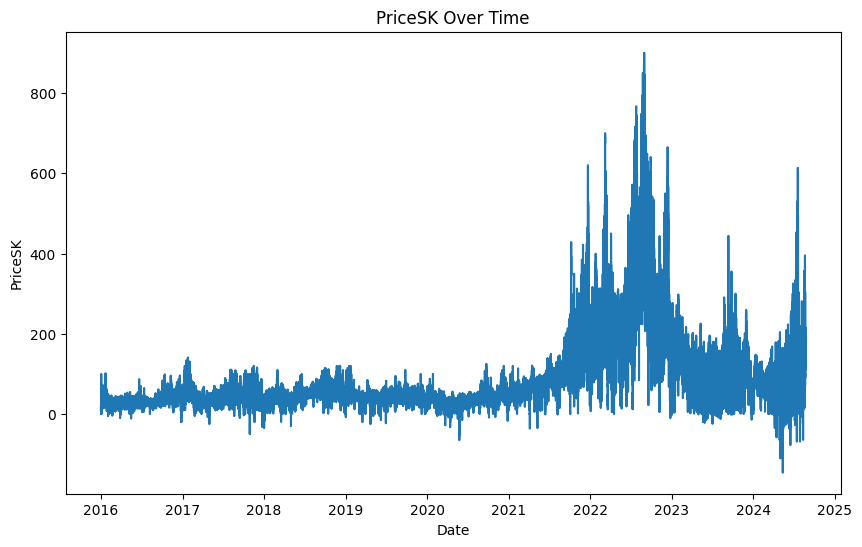

total datapoints 78912


In [ ]:
# Visualize potential outliers in the target variable
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['PriceSK'])
plt.title('PriceSK Over Time')
plt.xlabel('Date')
plt.ylabel('PriceSK')
plt.show()
print(f'total datapoints {len(data)}')

In [ ]:
# Calculate Z-scores for 'PriceSK'
z_scores = np.abs(stats.zscore(data['PriceSK']))

# Identify the indices of outliers (Z-score threshold > 3)
outliers = np.where(z_scores > 3)[0]  # Extract the first element to get the indices array

# Remove outliers from the DataFrame
data = data.drop(data.index[outliers])

# Verify outliers are removed
print("Outliers removed. Remaining data points:", len(data))

Outliers removed. Remaining data points: 78912


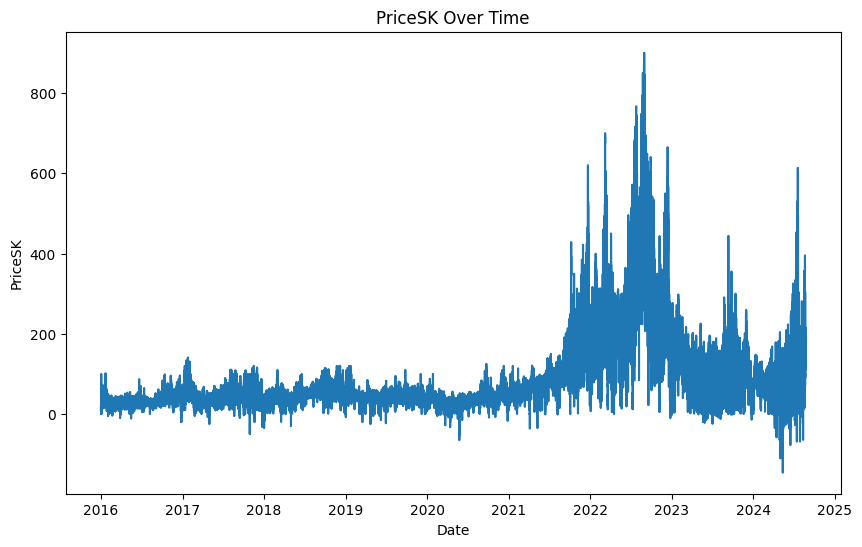

In [ ]:
# Visualize potential outliers in the target variable
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['PriceSK'])
plt.title('PriceSK Over Time')
plt.xlabel('Date')
plt.ylabel('PriceSK')
plt.show()

# Ploting New Features

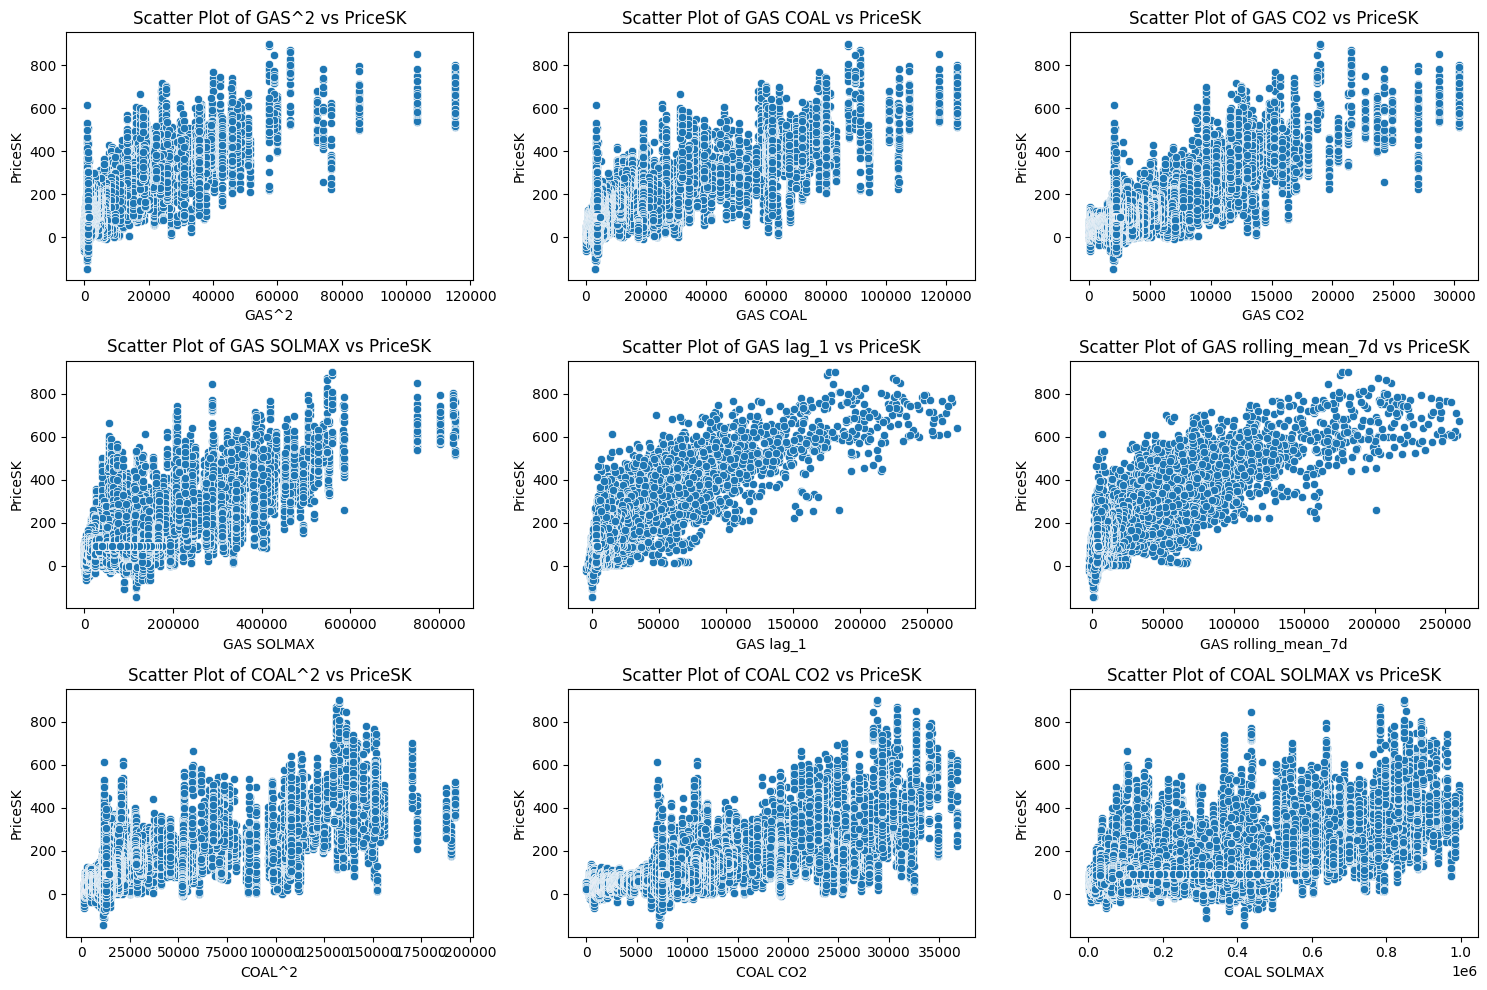

In [ ]:
# Filter out valid polynomial feature names that are 1-dimensional
valid_features = [feature for feature in poly_feature_names if data[feature].ndim == 1]

# Plot some of the new polynomial features against the target variable
plt.figure(figsize=(15, 10))

for i, feature in enumerate(valid_features[:9], 1):  # Limiting to the first 9 features for a 3x3 grid
    plt.subplot(3, 3, i)
    sns.scatterplot(x=data[feature], y=data['PriceSK'])
    plt.title(f'Scatter Plot of {feature} vs PriceSK')

plt.tight_layout()
plt.show()

# date range plotting

In [ ]:
# Define the column names to plot
column1 = 'RHBSOLGEN ATWINDGEN'  # Replace with the actual column name
column2 = 'UNAVLIGNBG'  # Replace with the actual column name
column3 = 'UNAVGASALL'  # Replace with the actual column name
column4 = 'ATWINDGEN'  # Replace with the actual column name
column5 = 'RORAT_HP'  # Replace with the actual column name
column6 = 'RHBSOLGEN'  # Replace with the actual column name

In [ ]:
# Define the date range for which you want to plot the data
start_date = '2018-01-01'  # Replace with the desired start date
end_date = '2018-02-01'  # Replace with the desired end date
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

In [ ]:
# Filter data for the specific date range
data_range = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Handle missing values in PriceSK and other columns
data_range['PriceHU'] = data_range['PriceHU'].interpolate(method='linear')
data_range['PriceHU'] = data_range['PriceHU'].bfill().ffill()  # Use bfill() and ffill() directly


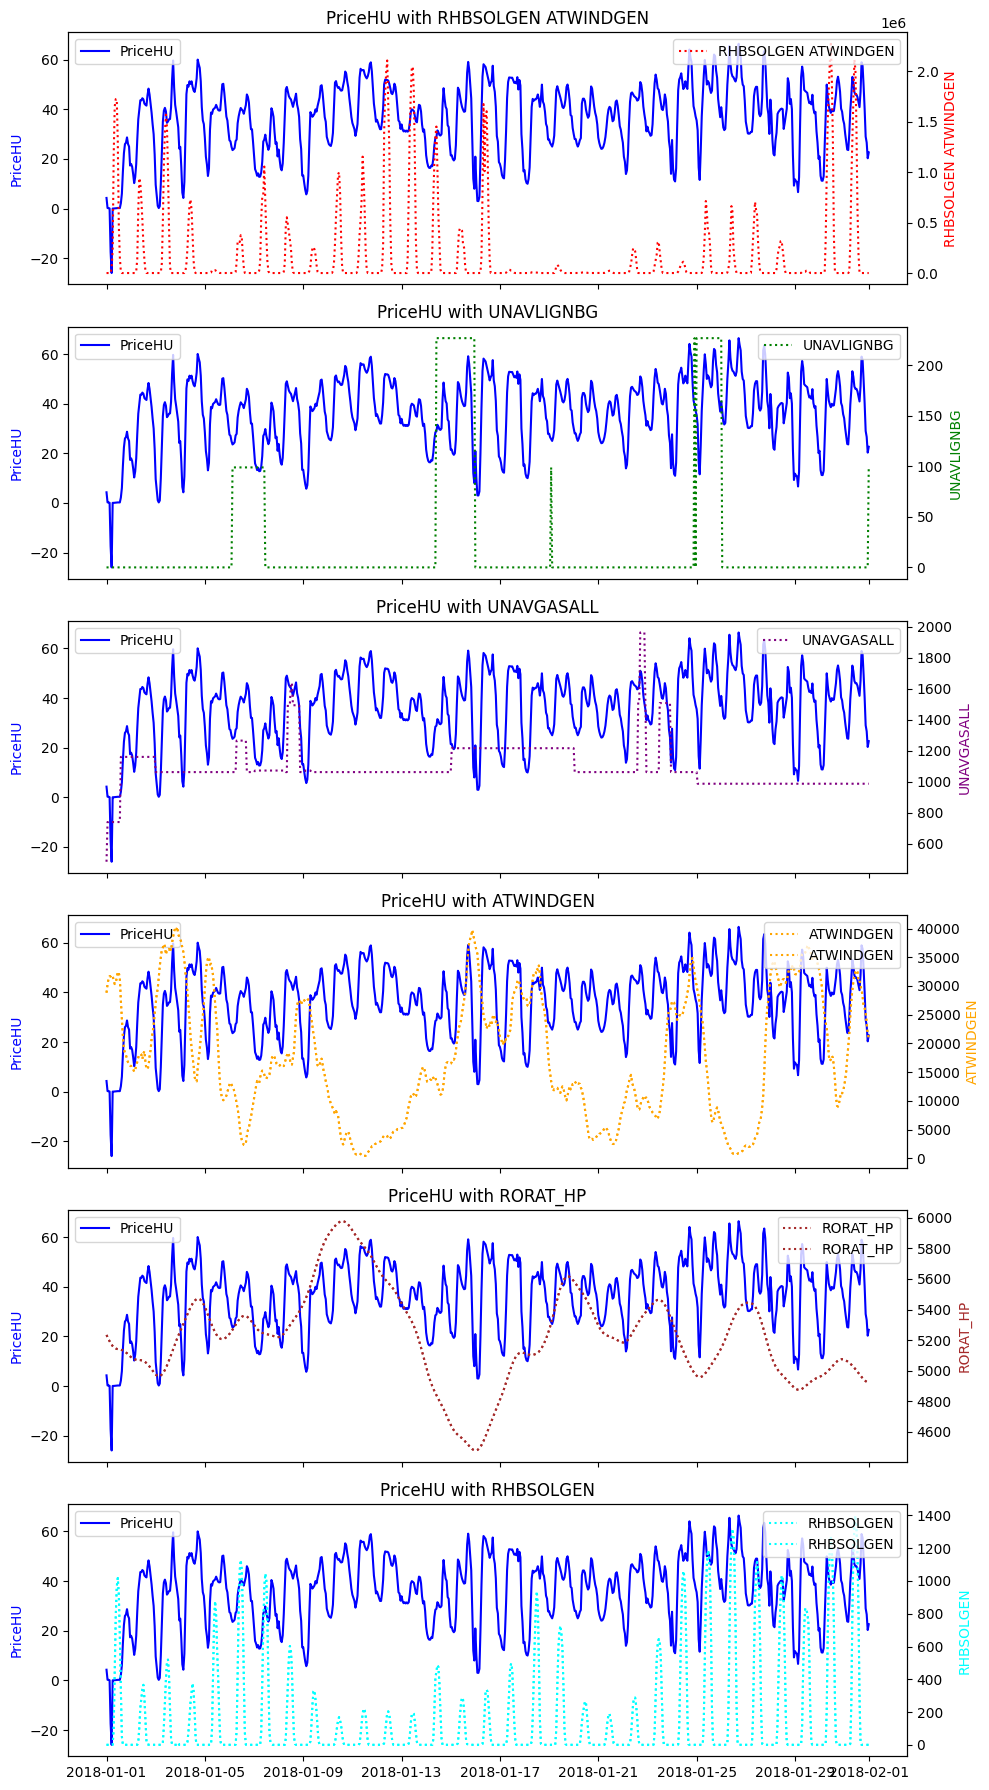

In [ ]:
# Initialize a figure with subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 18), sharex=True)  # 6 separate subplots

# Plotting function to create subplots with secondary y-axes
def create_plot(ax, y1, y2, y1_label, y2_label, color1, color2):
    ax.plot(data_range['Date'], data_range[y1], label=y1_label, color=color1, linestyle='-')
    ax.set_ylabel(y1_label, color=color1)
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.plot(data_range['Date'], data_range[y2], label=y2_label, color=color2, linestyle=':')
    ax2.set_ylabel(y2_label, color=color2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_title(f'{y1_label} with {y2_label}')

# Create plots for each subplot
create_plot(axes[0], 'PriceHU', column1, 'PriceHU', column1, 'blue', 'red')
create_plot(axes[1], 'PriceHU', column2, 'PriceHU', column2, 'blue', 'green')
create_plot(axes[2], 'PriceHU', column3, 'PriceHU', column3, 'blue', 'purple')
create_plot(axes[3], 'PriceHU', column4, 'PriceHU', column4, 'blue', 'orange')
create_plot(axes[4], 'PriceHU', column5, 'PriceHU', column5, 'blue', 'brown')
create_plot(axes[5], 'PriceHU', column6, 'PriceHU', column6, 'blue', 'cyan')

# Formatting and display
plt.xlabel('Date and Hour')
plt.tight_layout()
plt.show()

# Ploting PriceHU Only

In [ ]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data_interpolated['Date'] = pd.to_datetime(data_interpolated['Date'])

# Define the date range for plotting
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2018-02-01')

# Filter the data within the specified date range
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
filtered_data_interpolated = data_interpolated[(data_interpolated['Date'] >= start_date) & (data_interpolated['Date'] <= end_date)]

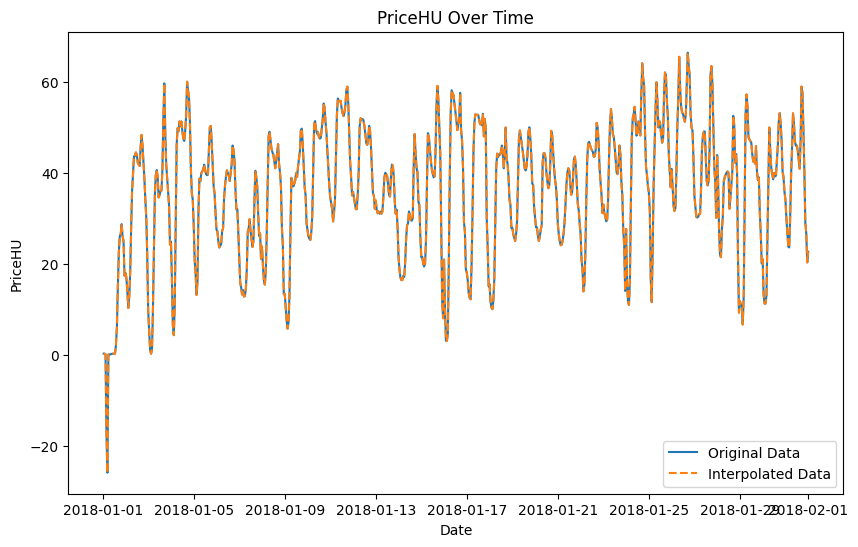

In [ ]:
# Plotting the original and interpolated data
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Date'], filtered_data['PriceHU'], label='Original Data')
plt.plot(filtered_data_interpolated['Date'], filtered_data_interpolated['PriceHU'], label='Interpolated Data', linestyle='--')

plt.xlabel('Date')
plt.ylabel('PriceHU')
plt.title('PriceHU Over Time')
plt.legend()
plt.show()